# AI's Evolutionary Path: What the Future Holds for Professions
### Part 2: NLP Customized Sentiment Analysis
### Author: Hyojun Kim

## Data Preparation

In [2]:
import sys
print(sys.version)

3.10.9 (main, Mar  1 2023, 12:20:14) [Clang 14.0.6 ]


In [3]:
import os
import time
import re
import pandas as pd
import numpy as np
from pandarallel import pandarallel
from multiprocessing import Pool, cpu_count
from transformers import pipeline
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FixedLocator
import matplotlib.dates as mdates
import seaborn as sns
from itertools import compress
import pickle 

import gensim
from gensim import corpora, models
from gensim.models import LdaMulticore, Phrases
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics

import spacy
import nltk
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


from transformers import BertTokenizerFast, BertForSequenceClassification
from torch.utils.data import DataLoader
from transformers import AdamW
import torch
from tqdm import tqdm


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)
from nltk.corpus import stopwords

In [4]:
import warnings

warnings.simplefilter('once')

import multiprocessing
from multiprocessing import Pool, cpu_count

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

workers = num_processors-1
print(f"Using {workers} workers")

#Verify we got CPU + GPU or only CPU
tf.config.list_physical_devices()

pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 8
Using 7 workers
INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### Copy files to local FS from GCP bucket

In [5]:
path_prep = '/Users/hyojun/Desktop/data/NLP/prep'
path_lda = '/Users/hyojun/Desktop/data/NLP/lda'
path_sentiment = '/Users/hyojun/Desktop/data/NLP/sentiment'

if not os.path.isdir(path_prep): os.mkdir(path_prep)
if not os.path.isdir(path_lda): os.mkdir(path_lda)
if not os.path.isdir(path_sentiment): os.mkdir(path_sentiment)

In [6]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

## Load the Final Data

In [7]:
# Load the DataFrame
classified_load_path = os.path.join(path_prep, 'classified_df.pkl')
classified_df = pd.read_pickle(classified_load_path)

## Exploratory Data Analysis 

In [8]:
# Statistical Summary
print 

<function print>

## Sentiment Analysis: VADAR and YELP

### Sentiment Analysis w/ VADER

In [9]:
%%time

# Function to perform sentiment analysis using VADER
def perform_sentiment_analysis(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_score = analyzer.polarity_scores(text)
    compound_score = sentiment_score['compound']
    
    # Categorize sentiment into 'positive' or 'negative' based on the compound score
    sentiment_category = 'positive' if compound_score >= 0 else ('negative')
    
    return compound_score, sentiment_category

# Apply sentiment analysis to the 'text_clean' column and create new columns 'vader_sentiment' and 'vader_sentiment_category'
classified_df['vader_sentiment'], classified_df['vader_sentiment_category'] = zip(*classified_df['text_clean'].parallel_apply(perform_sentiment_analysis))

CPU times: user 531 ms, sys: 1.56 s, total: 2.09 s
Wall time: 4min 53s


In [10]:
classified_df['vader_sentiment_category'].value_counts()

vader_sentiment_category
positive    150891
negative     10005
Name: count, dtype: int64

### Visualize Overall Sentiment Analysis w/ VADER

In [11]:
def plotting_sentiment(df, topic):
    fig, (ax_positive, ax_negative) = plt.subplots(1, 2, figsize=(15, 6), dpi=100, sharey=True)
    
    # Calculate sentiment proportions
    df['positive_proportion'] = df['rolling_positive'] / (df['rolling_positive'] + df['rolling_negative'])
    df['negative_proportion'] = df['rolling_negative'] / (df['rolling_positive'] + df['rolling_negative'])
    
    # Plot rolling averages for positive sentiment proportion on the left axis
    ax_positive.plot(df['date'], df['positive_proportion'], label="Positive Sentiments", color="darkgreen", linewidth=2, alpha=0.8)
    ax_positive.fill_between(df['date'], df['positive_proportion'], color="lightgreen", alpha=0.3)
    ax_positive.set_title(f'Timeline of Positive Sentiments (15-day Rolling Average) - {topic}', fontweight='bold')
    
    # Plot rolling averages for negative sentiment proportion on the right axis
    ax_negative.plot(df['date'], df['negative_proportion'], label="Negative Sentiments", color="darkred", linewidth=2, alpha=0.8)
    ax_negative.fill_between(df['date'], df['negative_proportion'], color="mistyrose", alpha=0.3)
    ax_negative.set_title(f'Timeline of Rolling Negative Sentiments (15-day Rolling Average) - {topic}', fontweight='bold')
    
    # Set x-axis tick parameters
    for ax in [ax_positive, ax_negative]:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # set the interval to 6 months
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # set the date format
        ax.tick_params(axis='x', rotation=45)
    
    # Add legend to both axes
    ax_positive.legend(loc='upper left', fontsize=10)
    ax_negative.legend(loc='upper left', fontsize=10)
    
    # Add gridlines and customize the grid
    for ax in [ax_positive, ax_negative]:
        ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

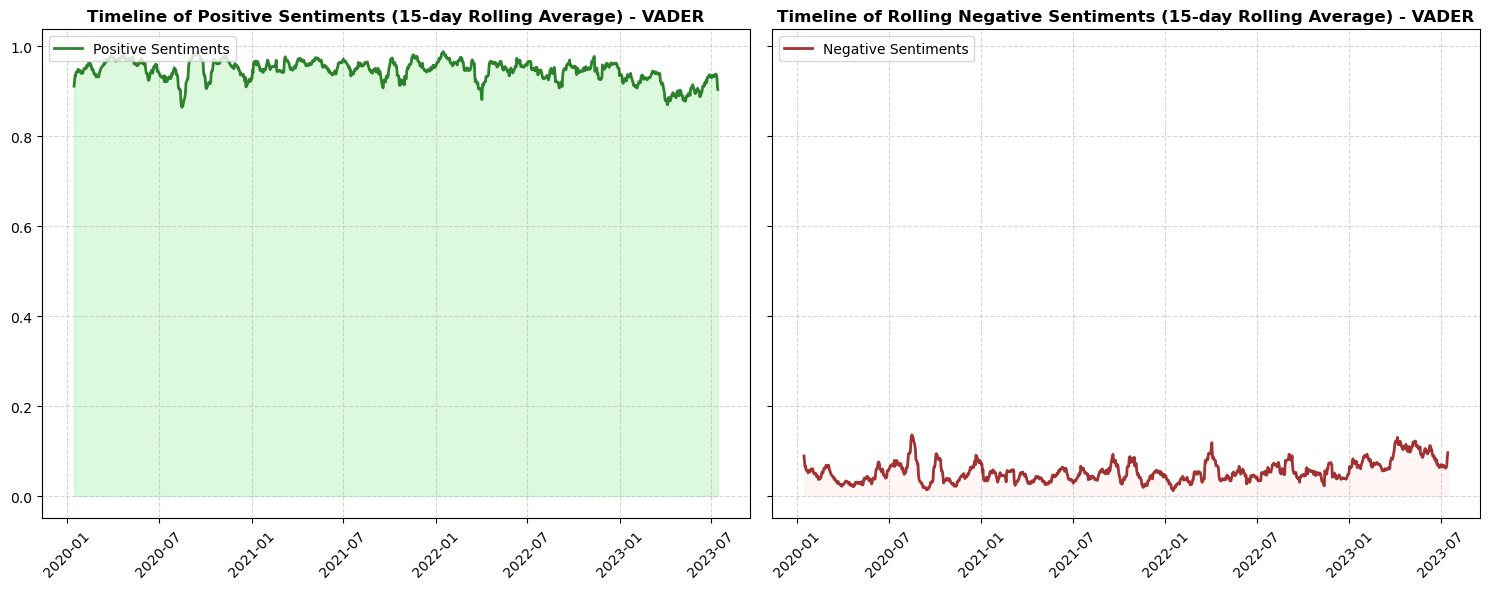

In [12]:
# First, let's calculate the counts of each sentiment category for each date
sentiment_counts = classified_df.groupby(['date', 'vader_sentiment_category']).size().unstack().fillna(0)

# Calculate the proportions for each sentiment category
sentiment_counts['total'] = sentiment_counts.sum(axis=1)
sentiment_counts['positive_proportion'] = sentiment_counts['positive'] / sentiment_counts['total']
sentiment_counts['negative_proportion'] = sentiment_counts['negative'] / sentiment_counts['total']

# Convert sentiment_counts to the expected format for plotting_sentiment
plotting_df = sentiment_counts.reset_index()[['date', 'positive_proportion', 'negative_proportion']]
plotting_df['rolling_positive'] = plotting_df['positive_proportion'].rolling(window=15).mean()
plotting_df['rolling_negative'] = plotting_df['negative_proportion'].rolling(window=15).mean()

# Call the plotting_sentiment function
plotting_sentiment(plotting_df, 'VADER')



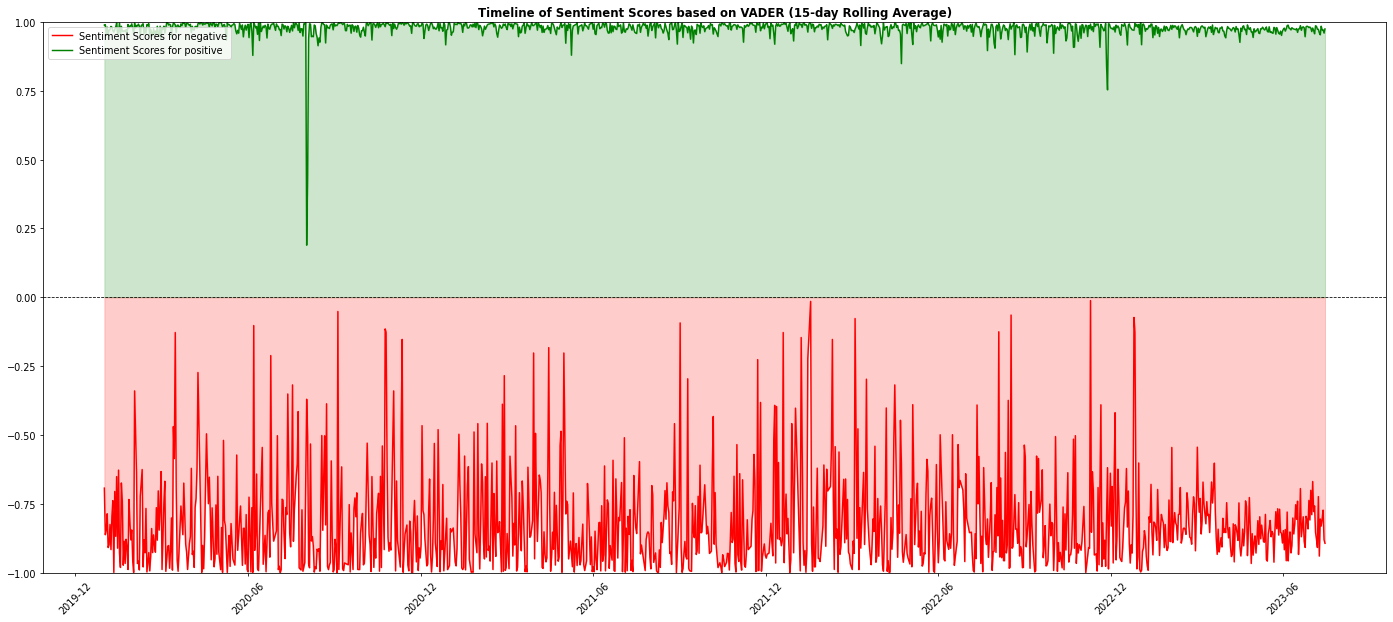

In [13]:
# Group by date and category to get average sentiment score
grouped_sentiments = classified_df.groupby(['date', 'vader_sentiment_category'])['vader_sentiment'].mean().unstack()


# Get unique categories
categories = grouped_sentiments.columns
# Use a 15-day rolling mean to smoothen the curves
rolling_sentiments = grouped_sentiments.rolling(window=15).mean()
fig, ax = plt.subplots(figsize=(20, 9), dpi=70)

# Loop to plot each category
for category in categories:
    category_sentiments = grouped_sentiments[category].dropna()  # Remove NaN values
    
    # Determine color based on sentiment
    if category == "positive":
        color = "green"
        alpha_fill = 0.2
    elif category == "negative":
        color = "red"
        alpha_fill = 0.2
    else:
        color = "gray"  # Neutral or other categories
        alpha_fill = 0.1
    
    # Plot sentiment scores for this category
    ax.plot(category_sentiments.index, category_sentiments, label=f"Sentiment Scores for {category}", color=color)
    ax.fill_between(category_sentiments.index, category_sentiments, color=color, interpolate=True, alpha=alpha_fill)

# Add a reference line at y=0 and other chart details
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')  # Line at y=0
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', rotation=45)
ax.set_title('Timeline of Sentiment Scores based on VADER (15-day Rolling Average)', fontweight="bold")
ax.set_ylim(-1, 1)  # Adjusting y-axis limits for VADER scores
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()



### Train Yelp for Sentiment Analysis:
    * Train Open Source Data: Yelp

In [14]:
%%time

yelp_path = '/Users/hyojun/Desktop/data/yelp_train_sentiment.json'
yelp = pd.read_json(yelp_path, orient='records', lines=True)

yelp = yelp.sample(frac=0.10, replace=False, random_state=1).reset_index(drop=True)
X = yelp['text']
y = yelp['label']
print(X.shape)
print(y.shape)

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=6)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

# Make a pipeline
pipe_logreg = make_pipeline(
    CountVectorizer(lowercase=False, stop_words='english', ngram_range=(1,3)),
    LogisticRegression(max_iter=1000)
)

%time pipe_logreg.fit(X_train, y_train)

%time y_pred = pipe_logreg.predict(X_test)
print("-"*5)
print(f"\nTest Accuracy: {metrics.accuracy_score(y_test, y_pred) * 100:.1f}%")

print(classification_report(y_test, y_pred))

(25572,)
(25572,)
(19179,)
(6393,)
(19179,)
(6393,)
CPU times: user 57.6 s, sys: 14.7 s, total: 1min 12s
Wall time: 18.1 s
CPU times: user 1.29 s, sys: 175 ms, total: 1.47 s
Wall time: 658 ms
-----

Test Accuracy: 95.5%
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3103
           1       0.96      0.95      0.96      3290

    accuracy                           0.96      6393
   macro avg       0.96      0.96      0.96      6393
weighted avg       0.96      0.96      0.96      6393

CPU times: user 59.7 s, sys: 15 s, total: 1min 14s
Wall time: 19.5 s


### Apply Yelp Sentiment Analysis (15D Rolling)

In [15]:
def apply_sentiment_analysis(df):
    df['yelp_sentiment'] = pipe_logreg.predict(df['text_clean'])
    return df

def sentiment_groupby(df):
    # Group by date and aggregate
    grouped = df.groupby('date').agg({'yelp_sentiment': ['sum', 'count']}).reset_index()
    grouped.columns = ['date', 'positive', 'total']

    # Calculate negative sentiments and proportions
    grouped['negative'] = grouped['total'] - grouped['positive']
    grouped['negative_proportion'] = grouped['negative'] / grouped['total']

    # Calculate positive sentiment proportion
    grouped['positive_proportion'] = grouped['positive'] / grouped['total']

    return grouped

def plotting_sentiment(df, topic):
    fig, (ax_positive, ax_negative) = plt.subplots(1, 2, figsize=(15, 6), dpi=100, sharey=True)
    
    # Calculate sentiment proportions
    df['positive_proportion'] = df['rolling_positive'] / (df['rolling_positive'] + df['rolling_negative'])
    df['negative_proportion'] = df['rolling_negative'] / (df['rolling_positive'] + df['rolling_negative'])
    
    # Plot rolling averages for positive sentiment proportion on the left axis
    ax_positive.plot(df['date'], df['positive_proportion'], label="Positive Sentiments", color="darkgreen", linewidth=2, alpha=0.8)
    ax_positive.fill_between(df['date'], df['positive_proportion'], color="lightgreen", alpha=0.3)
    ax_positive.set_title(f'Timeline of Positive Sentiments (15-day Rolling Average) - {topic}', fontweight='bold')
    
    # Plot rolling averages for negative sentiment proportion on the right axis
    ax_negative.plot(df['date'], df['negative_proportion'], label="Negative Sentiments", color="darkred", linewidth=2, alpha=0.8)
    ax_negative.fill_between(df['date'], df['negative_proportion'], color="mistyrose", alpha=0.3)
    ax_negative.set_title(f'Timeline of Rolling Negative Sentiments (15-day Rolling Average) - {topic}', fontweight='bold')
    
    # Set x-axis tick parameters
    for ax in [ax_positive, ax_negative]:
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))  # set the interval to 6 months
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # set the date format
        ax.tick_params(axis='x', rotation=45)
    
    # Add legend to both axes
    ax_positive.legend(loc='upper left', fontsize=10)
    ax_negative.legend(loc='upper left', fontsize=10)
    
    # Add gridlines and customize the grid
    for ax in [ax_positive, ax_negative]:
        ax.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

### Visualize Overall Sentiment Analysis w/ Yelp (15D Rolling)

Overall Sentiment: (1291, 8)


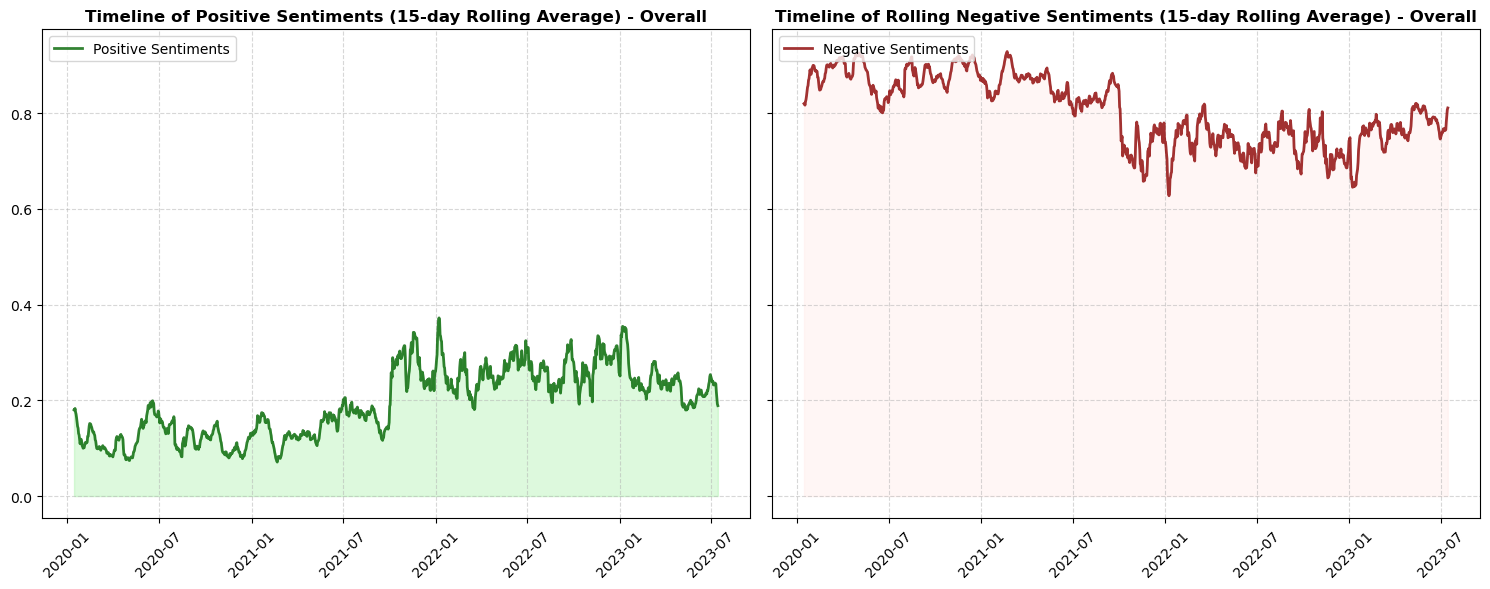

CPU times: user 2min 35s, sys: 2.72 s, total: 2min 38s
Wall time: 2min 41s


In [16]:
%%time

# Apply sentiment analysis to the entire dataset
classified_df = apply_sentiment_analysis(classified_df)

# Group the DataFrame by date and calculate sentiment statistics
grouped_df = sentiment_groupby(classified_df)

# Calculate rolling 15-day moving averages for positive and negative sentiments
grouped_df['rolling_positive'] = grouped_df['positive'].rolling(window=15).mean()
grouped_df['rolling_negative'] = grouped_df['negative'].rolling(window=15).mean()

print(f'Overall Sentiment: {grouped_df.shape}')

# Plot the sentiment results including rolling averages for positive and negative sentiments
plotting_sentiment(grouped_df, 'Overall')

Compared to Vader, the Yelp sentiment analysis model domain is not optimized to this project. Hence, blending analysis is required.

## Customized Blended Sentiment Analysis

### Perform Blended Sentiment Analysis on Each Topic (15D Rolling)

Covers:
- Blended Positive Sentiment on Classified Topics
- Blended Negative Sentiment on Classified Topics

Logic:

When vader_category != yelp_category:
- Trust Vader Sentiment when <= - 0.995 & >= 0.995
- Otherwise, trust Yelp Sentiment

In [17]:
def blended_sentiment(text):
    vader_compound, vader_category = perform_sentiment_analysis(text)
    
    # Predict using the Yelp-trained model
    yelp_prediction = pipe_logreg.predict([text])[0]
    yelp_category = 'positive' if yelp_prediction == 1 else 'negative'
    
    # Rule 1: Both are in agreement
    if vader_category == yelp_category:
        return vader_category
    
    # Rule 2: They contradict each other
    else:
        if vader_compound >= 0.995 or vader_compound <= -0.995:  # Trust VADER when its sentiment score is strongly positive or strongly negative
            return vader_category
        else:  # Otherwise trust Yelp
            return yelp_category

# Apply the modified blended_sentiment function
classified_df['blended_sentiment'] = classified_df['text_clean'].parallel_apply(blended_sentiment)

In [18]:
def sentiment_groupby_blended(df):
    # Create the grouped positive and negative counts as before
    df_positive = df[df['blended_sentiment'] == 'positive']
    df_negative = df[df['blended_sentiment'] == 'negative']
    
    df_positive_count = df_positive.groupby('date').size().reset_index(name='positive_count')
    df_negative_count = df_negative.groupby('date').size().reset_index(name='negative_count')
    
    merged = pd.merge(df_positive_count, df_negative_count, on='date', how='outer').fillna(0)
    merged['total'] = merged['positive_count'] + merged['negative_count']
    
    # Convert 'date' column to datetime type
    merged['date'] = pd.to_datetime(merged['date'])

    # Generate a continuous date range from the min to max date of df
    date_range = pd.date_range(start=df['date'].min(), end=df['date'].max())
    continuous_dates_df = pd.DataFrame(date_range, columns=['date'])

    # Merge the continuous date range with the merged data to ensure no date gaps
    merged_with_continuous_dates = pd.merge(continuous_dates_df, merged, on='date', how='left').fillna(0)

    return merged_with_continuous_dates

In [19]:
topics = ['ai_integration', 'ai_impact', 'ai_technology', 'ai_healthcare', 'ai_finance', 'ai_education', 'ai_legal']

# for topic in tqdm(topics, desc="Processing topics"):
#     # Create the dataframe for each topic
#     topic_df = classified_df[classified_df[topic] != ''][['url', 'date', 'language', 'title', 'text', 'text_clean', topic]]
#     topic_df['date'] = pd.to_datetime(topic_df['date'])  # convert to datetime format
    
#     # Apply blended sentiment analysis
#     topic_df['blended_sentiment'] = topic_df['text_clean'].parallel_apply(blended_sentiment)
#     topic_df.to_pickle(os.path.join(path_sentiment, f'{topic}.pkl'))
    
#     # Group by date and calculate sentiment statistics
#     grouped_topic_df = sentiment_groupby_blended(topic_df)

#     # Calculate rolling 15-day moving averages for positive sentiments
#     grouped_topic_df['rolling_positive'] = grouped_topic_df['positive_count'].rolling(window=15).mean()
#     grouped_topic_df['rolling_negative'] = grouped_topic_df['negative_count'].rolling(window=15).mean()

#     grouped_topic_df.to_pickle(os.path.join(path_sentiment, f'{topic}_sentiment.pkl'))

### Visualize Overall Blended Sentiment Analysis

Blended Sentiment: (1292, 6)


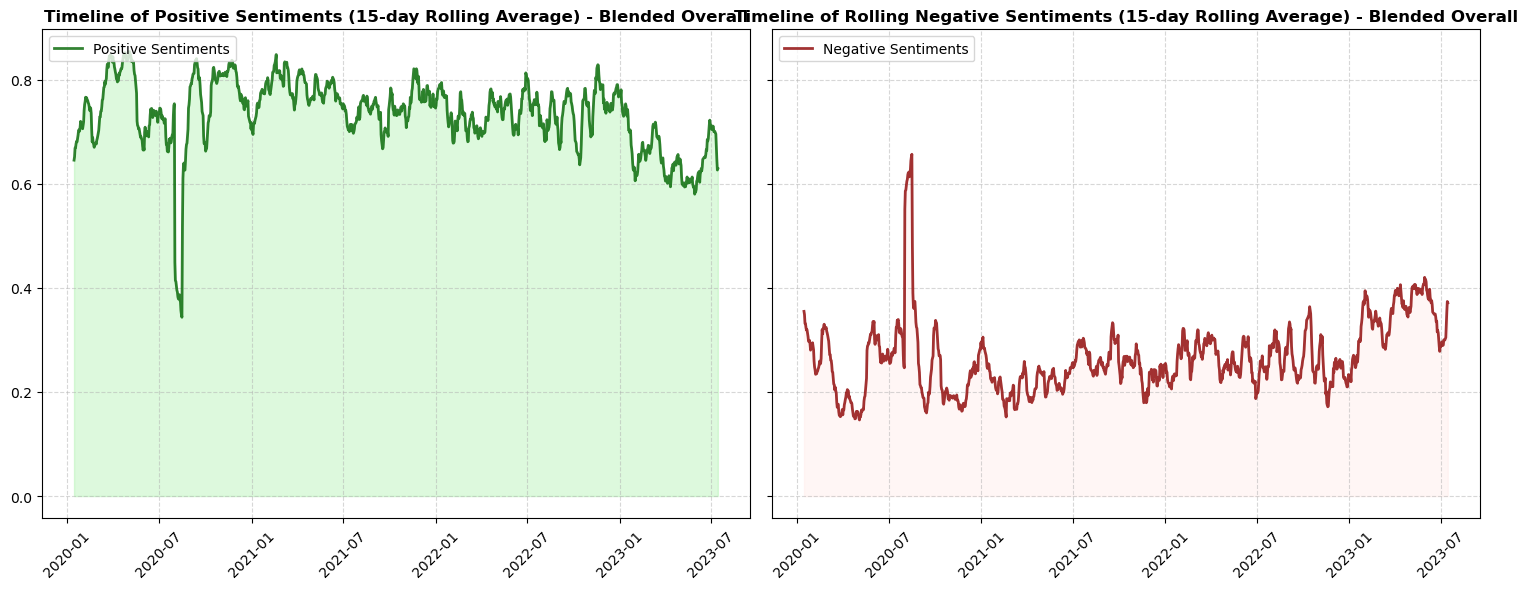

CPU times: user 1.48 s, sys: 2.54 s, total: 4.02 s
Wall time: 6min 10s


In [20]:
%%time

# Apply blended sentiment analysis to the entire dataset
classified_df['blended_sentiment'] = classified_df['text_clean'].parallel_apply(blended_sentiment)

# Group the DataFrame by date and calculate sentiment statistics based on blended sentiment
grouped_df_blended = sentiment_groupby_blended(classified_df)

# Calculate rolling 15-day moving averages for positive and negative sentiments based on blended sentiment
grouped_df_blended['rolling_positive'] = grouped_df_blended['positive_count'].rolling(window=15).mean()
grouped_df_blended['rolling_negative'] = grouped_df_blended['negative_count'].rolling(window=15).mean()

print(f'Blended Sentiment: {grouped_df_blended.shape}')

# Plot the sentiment results including rolling averages for positive and negative sentiments
plotting_sentiment(grouped_df_blended, 'Blended Overall')


In [21]:
def plot_overall_trend(topics, path_sentiment, rolling=True):
    plt.figure(figsize=(15, 6))
    
    positive_legend_handles = []
    negative_legend_handles = []

    # Define a techy color palette
    colors = ['#FFC107', '#28A745', '#6C757D', 'yellow', '#6F42C1', '#6C757D','#007BFF']

    # Step 1: Calculate frequency of each topic
    topic_frequencies = {}
    for topic in topics:
        grouped_topic_df = pd.read_pickle(os.path.join(path_sentiment, f'{topic}_sentiment.pkl'))
        topic_frequencies[topic] = grouped_topic_df['positive_count'].sum() + grouped_topic_df['negative_count'].sum()

    # Step 2: Sort topics based on frequency
    sorted_topics = [key for key, value in sorted(topic_frequencies.items(), key=lambda item: item[1], reverse=True)]
    
    if len(sorted_topics) > len(colors):
        raise ValueError("Please add more colors to the color palette to accommodate all topics.")

    # Plot based on sorted order
    for index, topic in enumerate(sorted_topics):
        color = colors[index]
        alpha_value = 0.4 if color == '#007BFF' else 1  # set transparency for blue, keep others opaque

        grouped_topic_df = pd.read_pickle(os.path.join(path_sentiment, f'{topic}_sentiment.pkl'))
        if rolling:
            positive_line, = plt.plot(grouped_topic_df['date'], grouped_topic_df['rolling_positive'], label=f'{topic} Positive Rolling', color=color, alpha=alpha_value)
            negative_line, = plt.plot(grouped_topic_df['date'], grouped_topic_df['rolling_negative'], label=f'{topic} Negative Rolling', linestyle='--', color=color, alpha=alpha_value)
        else:
            positive_line, = plt.plot(grouped_topic_df['date'], grouped_topic_df['positive_count'], label=f'{topic} Positive', color=color, alpha=alpha_value)
            negative_line, = plt.plot(grouped_topic_df['date'], grouped_topic_df['negative_count'], label=f'{topic} Negative', linestyle='--', color=color, alpha=alpha_value)

        positive_legend_handles.append(positive_line)
        negative_legend_handles.append(negative_line)

    # Setting plot properties
    plt.title('Overall Sentiment Trend Sorted by Frequency')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Creating two legends: one for positive trends and one for negative trends
    legend1 = plt.legend(handles=positive_legend_handles, loc='upper left')
    plt.gca().add_artist(legend1)
    plt.legend(handles=negative_legend_handles, loc='lower left')

    plt.show()


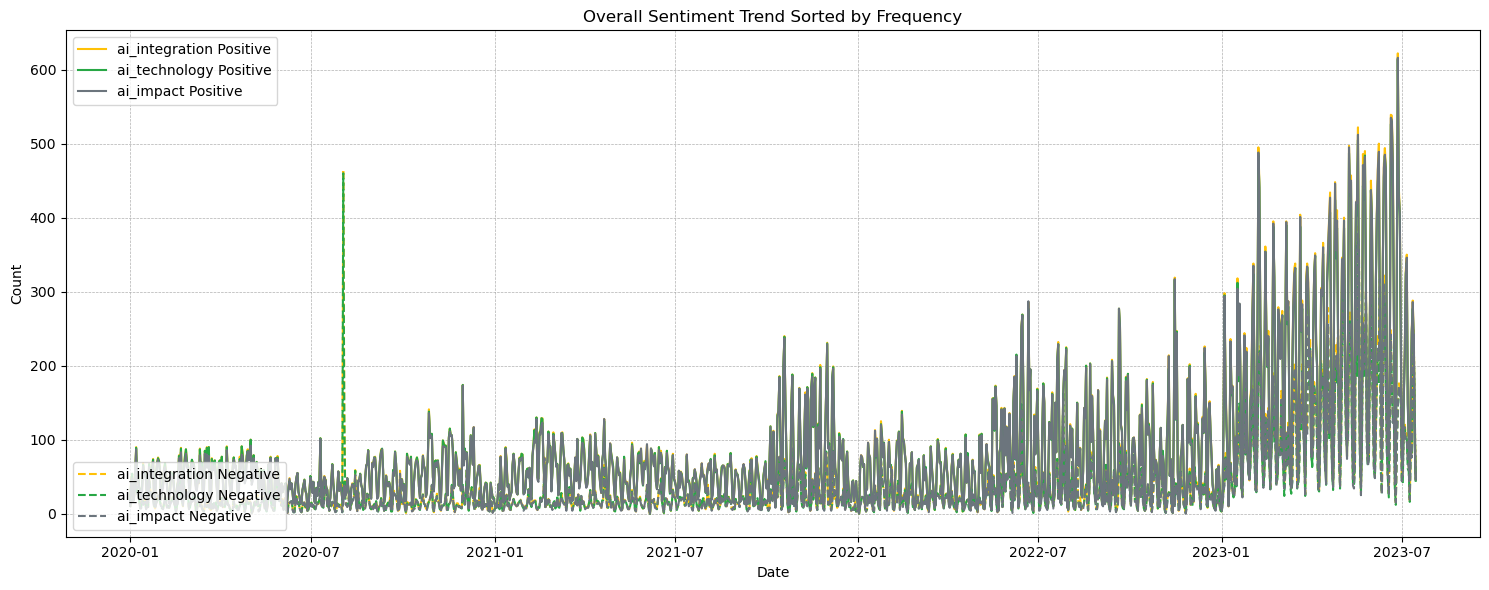

In [22]:
# Usage
topics_example = ['ai_integration', 'ai_impact', 'ai_technology']
plot_overall_trend(topics_example, path_sentiment, rolling=False) 


### Checkpoint

In [23]:
%%time

# Read pkl file
ai_integration= pd.read_pickle(os.path.join(path_sentiment, 'ai_integration_sentiment.pkl'))
ai_impact = pd.read_pickle(os.path.join(path_sentiment, 'ai_impact_sentiment.pkl'))
ai_technology = pd.read_pickle(os.path.join(path_sentiment, 'ai_technology_sentiment.pkl'))
ai_healthcare = pd.read_pickle(os.path.join(path_sentiment, 'ai_healthcare_sentiment.pkl'))
ai_finance = pd.read_pickle(os.path.join(path_sentiment, 'ai_finance_sentiment.pkl'))
ai_education = pd.read_pickle(os.path.join(path_sentiment, 'ai_education_sentiment.pkl'))
ai_legal = pd.read_pickle(os.path.join(path_sentiment, 'ai_legal_sentiment.pkl'))

CPU times: user 14.6 ms, sys: 1.8 ms, total: 16.4 ms
Wall time: 6.2 ms


### Unique Articles

In [24]:
for topic in topics:
    print(f"Topic: {topic} - Unique Articles: {len(classified_df[classified_df[topic] != ''])}")

Topic: ai_integration - Unique Articles: 159620
Topic: ai_impact - Unique Articles: 153834
Topic: ai_technology - Unique Articles: 154670
Topic: ai_healthcare - Unique Articles: 115042
Topic: ai_finance - Unique Articles: 134188
Topic: ai_education - Unique Articles: 138961
Topic: ai_legal - Unique Articles: 143552


### Visualize Classified Modeling Blended Sentiment Analysis (15D Rolling)
- Group 1:
    - AI Integration
    - AI Impact
    - AI Technology
- Group 2:
    - AI Healthcare
    - AI Finance
    - AI Education
    - AI Legal

In [25]:
# Create a list of dataframes contAI Evolutionary Pathning sentiment information for each topic and subset
sentiments = [
    ai_integration,
    ai_impact,
    ai_technology,
    ai_healthcare,
    ai_finance,
    ai_education,
    ai_legal
]

# Specify the labels for each line in the plot
labels_group1 = ["AI Integration", "AI Impact", "AI Technology"]
labels_group2 = ["AI Healthcare", "AI Technology", "AI Finance", "AI Education", "AI Legal"]

# Define the new color and line style palettes with changes for each topic
colors_group1 = ["#DAA520", "#369fc2", "#654321"]
colors_group2 = ["red", "#654321", "#000", "darkgreen", "orange"]
linestyles_group1 = ["solid", "solid", "solid"]
linestyles_group2 = ["solid", 'solid', "solid", "solid", "solid"]

### Visualize Classified AI Integration, AI Impact, and AI Tech Simultaneously

### Sentiment Analysis - Rolling Mean

In [26]:
def plot_sentiment(ax, step, sentiment_dfs, labels, colors, linestyles):
    legend_handles = []

    for i, (sentiment_df, label, color, linestyle) in enumerate(zip(sentiment_dfs, labels, colors, linestyles)):
        
        # Plot positive rolling mean
        positive_line, = ax.plot(sentiment_df['date'][::step], sentiment_df['rolling_positive'][::step], label=f'{label} Positive', color=color, linestyle=linestyle, linewidth=1.5)
        legend_handles.append(positive_line)
        
        # Plot negative rolling mean with dashed linestyle for differentiation
        negative_line, = ax.plot(sentiment_df['date'][::step], sentiment_df['rolling_negative'][::step], label=f'{label} Negative', color=color, linestyle='--', linewidth=1.5)
        legend_handles.append(negative_line)
    
    # Set title and axis labels
    ax.set_title('Rolling Mean Sentiments over Time (15D Rolling)', fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Rolling Mean Value')
    
    # Set grid and tick parameters
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)
    
    # Set color cycle
    ax.set_prop_cycle(color=colors)
    
    # Create legends. We position positive trends to upper left and negative trends to bottom left.
    positive_handles = [handle for handle in legend_handles if 'Positive' in handle.get_label()]
    negative_handles = [handle for handle in legend_handles if 'Negative' in handle.get_label()]
    
    legend1 = ax.legend(handles=positive_handles, loc='upper left')
    legend2 = ax.legend(handles=negative_handles, loc='lower left')
    
    # Add the first legend manually to the current Axes.
    ax.add_artist(legend1)



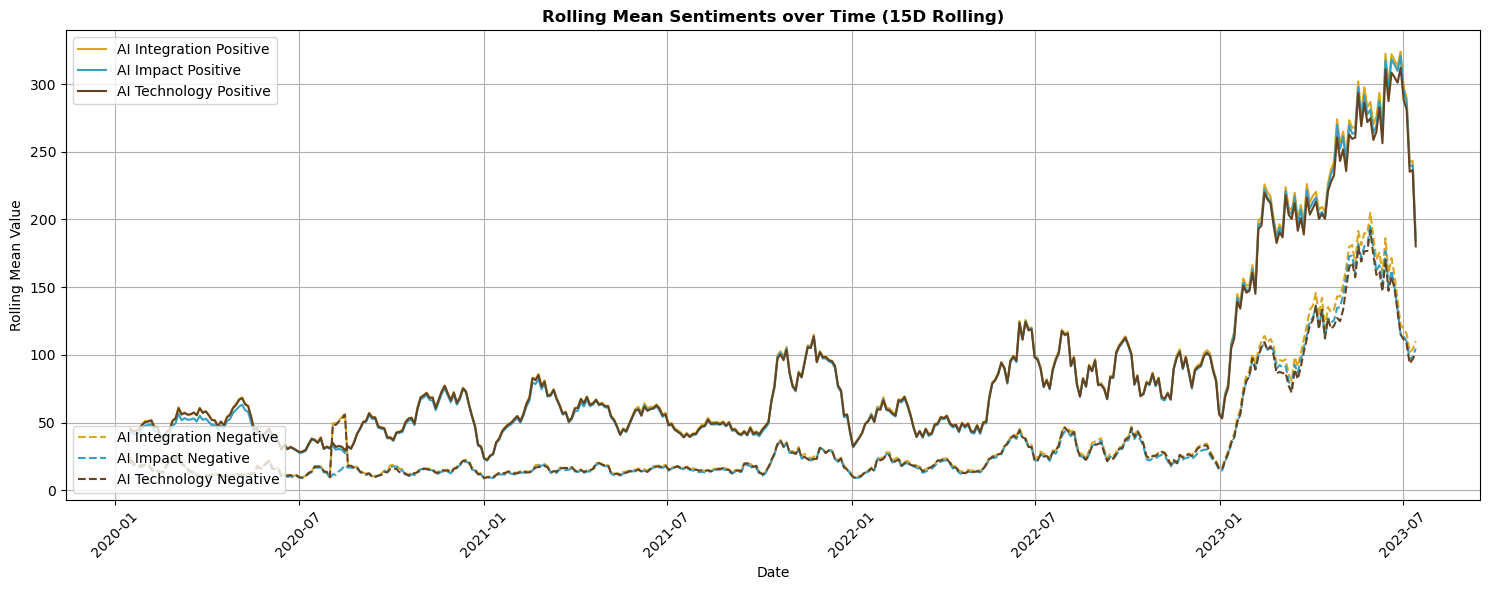

In [27]:
# Create the subplot
fig, ax = plt.subplots(figsize=(15, 6), dpi=100)

# Plot combined sentiments
plot_sentiment(ax, len(labels_group1), sentiments, labels_group1, colors_group1, linestyles_group1)

plt.tight_layout()
plt.show()


### Sentiment Analaysis - Proportion

In [28]:
def plot_combined_sentiment(ax, step, sentiment_dfs, labels, colors, linestyles):
    positive_legend_handles = []
    negative_legend_handles = []
    
    # Create two subplots: one for positive sentiments and one for negative sentiments
    ax1 = ax[0]
    ax2 = ax[1]
    
    for i, (sentiment_df, label, color, linestyle) in enumerate(zip(sentiment_dfs, labels, colors, linestyles)):
        # Calculate the proportions
        total = sentiment_df['rolling_positive'][::step] + sentiment_df['rolling_negative'][::step]
        
        positive_proportion = sentiment_df['rolling_positive'][::step] / total
        negative_proportion = 1 - positive_proportion
        
        # Plot positive sentiment proportion on the left subplot
        positive_line, = ax1.plot(sentiment_df['date'][::step], positive_proportion, label=f'{label} Positive', color=color, linestyle=linestyle, linewidth=1.5)
        positive_legend_handles.append(positive_line)
        
        # Plot negative sentiment proportion on the right subplot
        negative_line, = ax2.plot(sentiment_df['date'][::step], negative_proportion, label=f'{label} Negative', color=color, linestyle='--', linewidth=1.5)
        negative_legend_handles.append(negative_line)
    
    # Set titles and axis labels for both subplots
    ax1.set_title('Positive Sentiments over Time (15D Rolling)', fontweight='bold')
    ax2.set_title('Negative Sentiments over Time (15D Rolling)', fontweight='bold')
    ax2.set_xlabel('Date')
    ax1.set_ylabel('Sentiment Proportion')
    
    # Set grid and tick parameters for both subplots
    ax1.grid(True)
    ax2.grid(True)
    ax2.tick_params(axis='x', rotation=45)
    
    # Set color cycle for both subplots
    ax1.set_prop_cycle(color=colors)
    ax2.set_prop_cycle(color=colors)
    
    # Draw a horizontal line at y=0.5 for clear separation on both subplots
    ax1.axhline(0.5, color='black', linewidth=0.5)
    ax2.axhline(0.5, color='black', linewidth=0.5)
    
    # Set the y-axis limits for proportionate sentiments from 0 to 1 on both subplots
    ax1.set_ylim(0, 1)
    ax2.set_ylim(0, 1)
    
    # Creating two legends: one for positive trends and one for negative trends
    legend1 = ax1.legend(handles=positive_legend_handles, loc='upper left')
    legend2 = ax2.legend(handles=negative_legend_handles, loc='upper left')

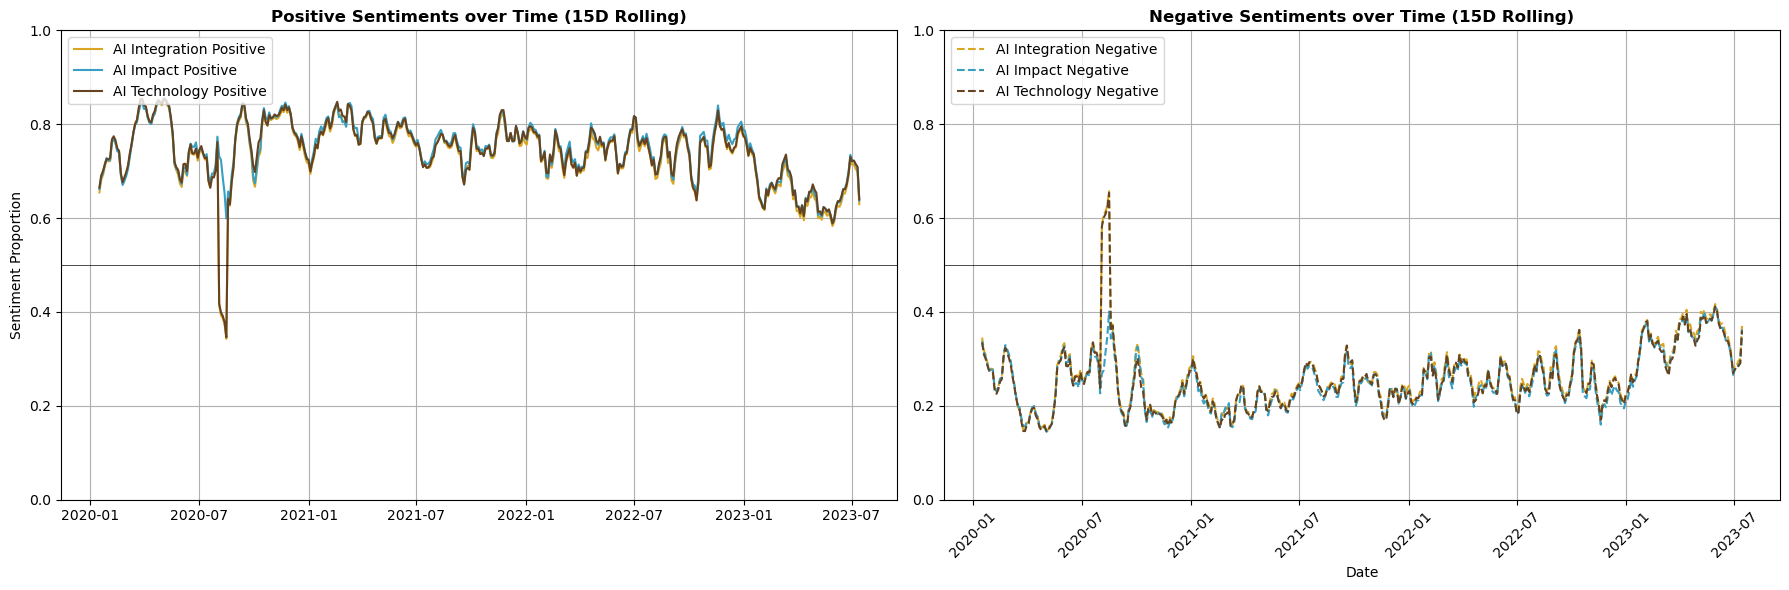

In [29]:
# Create the subplot
fig, axs = plt.subplots(1, 2, figsize=(18, 6), dpi=100)

# Plot combined sentiments for Group 1
plot_combined_sentiment(axs, len(labels_group1), sentiments, labels_group1, colors_group1, linestyles_group1)

plt.tight_layout()
plt.show()


### Visualize Classified Healthcare, Tech, Finance, Education, and Legal Simultaneously

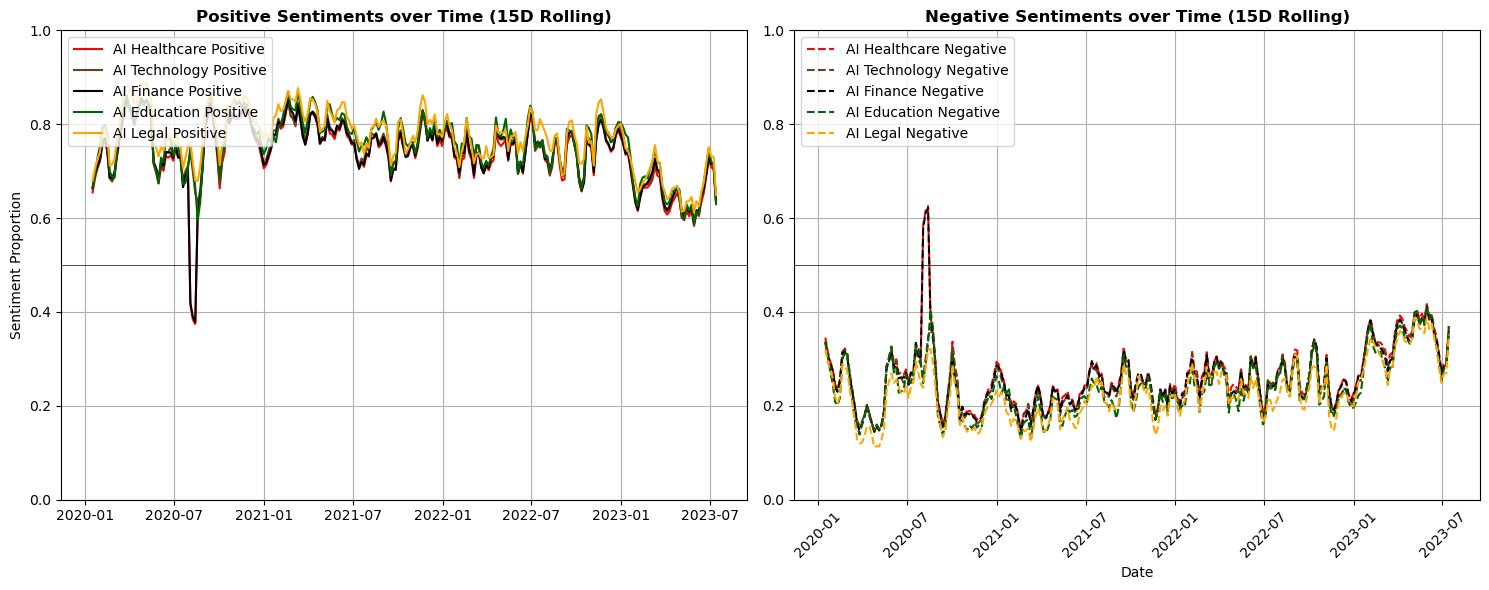

In [30]:
# Create the subplot
fig, axs = plt.subplots(1, 2, figsize=(15, 6), dpi=100)

# Plot combined sentiments for Group 2
plot_combined_sentiment(axs, len(labels_group2), sentiments, labels_group2, colors_group2, linestyles_group2)

plt.tight_layout()
plt.show()